# Aggregating Census Data with the ForkJoin Framework

In [115]:
import subprocess
import seaborn
import pandas as pd
%matplotlib inline

In [61]:
#version: 0 = SimpleSequential, 1 = SimpleForkJoin, 2 = GridSequential, ...
#action: 0 = reindex, 1 = query

def call_test(version, action, numReps, xRes, yRes, gran = 200):
    cmd = ['java', 'PerformanceTester', str(version), str(action), str(numReps), str(xRes), str(yRes), str(gran)]
    return float(subprocess.check_output(cmd)) / numReps / 1000 #lets use ms

In [97]:
corner_time_1 = call_test(0, 1, 50, 3, 3, 10000)
query_time_1 = call_test(0, 0, 50, 3, 3, 10000)
print(corner_time_1)
print(query_time_1)

2904.48
4737.7


## SimpleSequentialQuerySolver

SimpleSequentialQuerySolver solves queries with time complexity $\Theta(n)$ where n is the size of the census data set.  Before accepting queries, SimpleSequentialQuerySolver must find the corners of the smallest rectangle enclosing all census data points.  This operation also has time complexity $\Theta(n)$.  Grid dimensions do not affect time complexity. On my macbook pro, finding the corners takes about 4500 ms and querying the population takes about 3200 ms

## SimpleForkJoinQuerySolver
The simple ForkJoin query solver works similarly to the simple sequential query solver except it uses the ForkJoin framework to parallelize corner finding and querying.  This performance of SimpleSequentialQuerySolver depends on it's granularity, i.e. the largest chunk size that a single ForkJoin task will handle without forking.  To find the best granularity, we will simply test a few values and guess which granularity maximizes the performance of each operation. We shall begin with $granularity = 100$ since lower values (around 10) cause us to create too many tasks and run out of memory.

There is a tradeoff between parallelism and task overhead which suggests a unimodal time / granularity curve (single global minimum at inflection point). Unfortunately, my macbook only has one core with hyperthreading (or possibly two cores without hyperthreading).  This prevents parallelism from having any benefit. We observe a minimum at $granularity = 250,000$ which is larger than the data size.  At this granularity, a single task executes sequentially.  There is no parallelism whatsoever. 

In [128]:
granularity_test_points = [100, 500, 1000, 5000, 10000, 50000, 100000, 250000]
index_times = [call_test(1, 0, 50, 3, 3, g) for g in granularity_test_points]

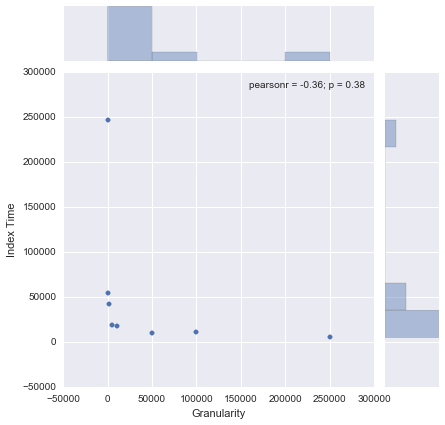

In [129]:
data = {
    'Granularity': granularity_test_points,
    'Index Time': index_times
}

dfrm = pd.DataFrame(data)

seaborn.jointplot(x='Granularity', y='Index Time', data=dfrm)

## GridSequentialQuerySolver

GridSequentialQuerySolver builds a grid so that it may solve queries in constant time.